In [29]:
import tensorflow as tf
import keras  # Now, Keras 3 is a separate package
import tensorflow_datasets as tfds
import joblib


#https://www.tensorflow.org/datasets/keras_example

### Load a dataset

In [30]:
(ds_train, ds_val, ds_test), ds_info = tfds.load(
    'mnist',
    split=['train[:90%]', 'train[90%:]', 'test'],
    shuffle_files=True,
    as_supervised=True,
    with_info=True,
)


### Create synthetic images of plus and minus

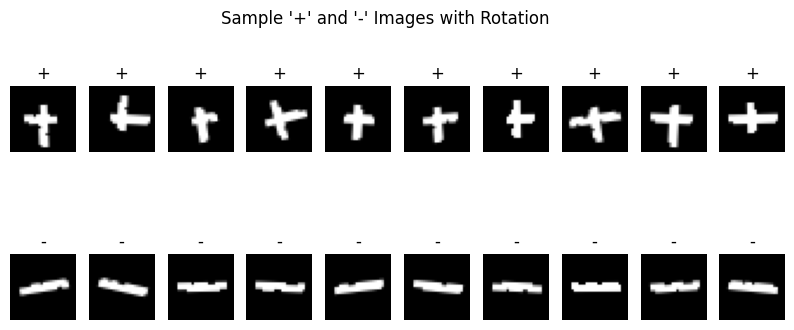

Custom dataset shape: (60000, 28, 28, 1)
Custom labels shape: (60000,)


In [31]:
import random
from PIL import Image, ImageDraw
import matplotlib.pyplot as plt
import numpy as np

import random
from PIL import Image, ImageDraw
import numpy as np

def generate_plus_image(
    stroke_min=2, 
    stroke_max=2,
    wiggle=0.2,            # random offset
    left_h_range=(3, 10),    # random half-length for the left part
    right_h_range=(3, 10),   # random half-length for the right part
    top_v_range=(4, 10),     # random half-length for the top part
    bottom_v_range=(3, 10),  # random half-length for the bottom part
    rotation_range=(-15, 15)
):
    """
    Generates a 28x28 plus sign, allowing the left/right and top/bottom lengths
    to differ. This creates an asymmetrical plus sign.
    """
    # Random stroke thickness
    stroke = random.randint(stroke_min, stroke_max)
    
    # Random half-lengths for each direction
    left_h_len = random.randint(*left_h_range)
    right_h_len = random.randint(*right_h_range)
    top_v_len = random.randint(*top_v_range)
    bottom_v_len = random.randint(*bottom_v_range)
    
    img = Image.new("L", (28, 28), color=0)
    draw = ImageDraw.Draw(img)
    center = 14
    
    # Draw horizontal stroke: from (center - left_h_len) to (center + right_h_len)
    for x in range(center - left_h_len, center + right_h_len + 1):
        y_center = center + random.uniform(-wiggle, wiggle)
        draw.rectangle(
            [
                (x - stroke//2, y_center - stroke//2),
                (x + stroke//2, y_center + stroke//2)
            ],
            fill=255
        )
        
    # Draw vertical stroke: from (center - top_v_len) to (center + bottom_v_len)
    for y in range(center - top_v_len, center + bottom_v_len + 1):
        x_center = center + random.uniform(-wiggle, wiggle)
        draw.rectangle(
            [
                (x_center - stroke//2, y - stroke//2),
                (x_center + stroke//2, y + stroke//2)
            ],
            fill=255
        )
    
    # Random rotation
    rotation = random.uniform(*rotation_range)
    if rotation != 0:
        img = img.rotate(rotation, resample=Image.BILINEAR, center=(center, center))
    
    return np.array(img, dtype=np.uint8)



def generate_minus_image(
    stroke_min=2, stroke_max=2,
    wiggle=0.2,       # maximum horizontal offset per step
    line_length=9,    # how far from center to go on each side
    rotation_range=(-15, 15)  # rotation angle range in degrees
):
    """
    Creates a 28x28 minus sign with 'handwritten' jitter.
    stroke_min/stroke_max control thickness range,
    wiggle controls random offset on each small segment,
    line_length is half the minus sign's total length from center.
    rotation_range allows rotating the minus sign by specified degrees.

    Return: A numpy array of shape (28, 28) in uint8 [0..255].
    """
    # Randomly pick the stroke thickness for this sign
    stroke = random.randint(stroke_min, stroke_max)
    
    # Create empty image
    img = Image.new("L", (28, 28), color=0)  # black background
    draw = ImageDraw.Draw(img)
    
    center = 14
    
    # Draw horizontal stroke: from (center - line_length) to (center + line_length)
    x_start = center - line_length
    x_end   = center + line_length
    
    # We'll move in small steps along the x-axis
    for x in range(x_start, x_end + 1):
        # For each x, the y center is 'center', but let's add some random wiggle
        y_center = center + random.uniform(-wiggle, wiggle)
        
        # Draw a small "blob" around (x, y_center)
        # stroke//2 is the half-thickness around the center
        draw.rectangle(
            [
                (x - stroke//2, y_center - stroke//2),
                (x + stroke//2, y_center + stroke//2)
            ],
            fill=255
        )
    
    # Random rotation
    rotation = random.uniform(*rotation_range)
    if rotation != 0:
        img = img.rotate(rotation, resample=Image.BILINEAR, center=(center, center))
    
    return np.array(img, dtype=np.uint8)

# Number of samples to generate per symbol
num_samples = 30000

# Generate raw samples for plus and minus with random rotations
plus_images = []
minus_images = []

for _ in range(num_samples):
    # Random rotation between -15 and 15 degrees
    plus_images.append(generate_plus_image())
    
    # Random rotation between -15 and 15 degrees
    minus_images.append(generate_minus_image())

# Display a sample grid (just to verify visually)
plt.figure(figsize=(10, 4))
for i in range(10):
    plt.subplot(2, 10, i+1)
    plt.imshow(plus_images[i], cmap='gray')
    plt.title("+")
    plt.axis('off')
    
    plt.subplot(2, 10, i+11)
    plt.imshow(minus_images[i], cmap='gray')
    plt.title("-")
    plt.axis('off')
plt.suptitle("Sample '+' and '-' Images with Rotation")
plt.show()

# Convert images to NumPy arrays
X_plus = np.array(plus_images, dtype=np.uint8)
X_minus = np.array(minus_images, dtype=np.uint8)

# Create labels (using "+" and "-" as labels instead of 10 and 11)
y_plus = np.array(["10"] * num_samples, dtype=np.int64)
y_minus = np.array(["11"] * num_samples, dtype=np.int64)

# Combine plus/minus data
X_custom = np.vstack([X_plus, X_minus])
y_custom = np.concatenate([y_plus, y_minus])

# Reshape to match MNIST format: (samples, 28, 28, 1)
X_custom = X_custom.reshape(-1, 28, 28, 1)

print("Custom dataset shape:", X_custom.shape)
print("Custom labels shape:", y_custom.shape)


### Split custom data to match MNIST training/validation split

In [32]:
from sklearn.model_selection import train_test_split

# First, split off 10% for test.
X_custom_train_val, X_custom_test, y_custom_train_val, y_custom_test = train_test_split(
    X_custom, y_custom, test_size=0.1, random_state=42)

# of the new train set we split 90% training, 10% validation
X_custom_train, X_custom_val, y_custom_train, y_custom_val = train_test_split(
    X_custom_train_val, y_custom_train_val, test_size=0.1, random_state=42)

print("Custom Train Shape:", X_custom_train.shape)
print("Custom Val Shape:", X_custom_val.shape)
print("Custom Test Shape:", X_custom_test.shape)


Custom Train Shape: (48600, 28, 28, 1)
Custom Val Shape: (5400, 28, 28, 1)
Custom Test Shape: (6000, 28, 28, 1)


### convert each split into a tf.data.Dataset

In [33]:
ds_custom_train = tf.data.Dataset.from_tensor_slices((X_custom_train, y_custom_train))
ds_custom_val   = tf.data.Dataset.from_tensor_slices((X_custom_val,   y_custom_val))
ds_custom_test  = tf.data.Dataset.from_tensor_slices((X_custom_test,  y_custom_test))

# These are also unbatched: each element is shape [28,28,1], label is a scalar


In [38]:
from keras.models import Sequential
from keras.layers import RandomRotation, RandomZoom, RandomTranslation

data_augmentation = Sequential([
    RandomRotation(0.01),
    RandomZoom(0.1),
    RandomTranslation(height_factor=0.2, width_factor=0.2),
])


In [39]:
def normalize_img(image, label):
    """Normalizes images: uint8 -> float32 in [0..1]."""
    return tf.cast(image, tf.float32) / 255.0, label


def preprocess_dataset(ds, training=False):
    # 1) Normalize
    ds = ds.map(normalize_img, num_parallel_calls=tf.data.AUTOTUNE)
    
    # 2) Augment if training
    if training:
        ds = ds.map(lambda x, y: (data_augmentation(x, training=True), y),
                    num_parallel_calls=tf.data.AUTOTUNE)
    
    # 3) Shuffle if training
    if training:
        ds = ds.shuffle(10000)
    
    # 4) Batch & Prefetch
    ds = ds.batch(128)
    ds = ds.prefetch(tf.data.AUTOTUNE)
    
    return ds

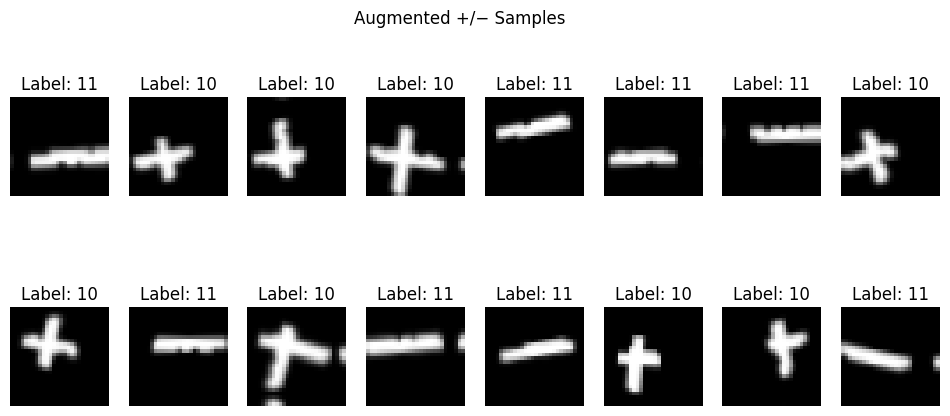

2025-03-20 10:11:35.891529: I tensorflow/core/framework/local_rendezvous.cc:407] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence


In [40]:
import matplotlib.pyplot as plt

# Suppose ds_custom_train is already unbatched:
#  1) Take 16 examples
ds_debug = ds_custom_train.take(16)

#  2) Apply the same transformations you do in training
ds_debug = ds_debug.map(normalize_img, num_parallel_calls=tf.data.AUTOTUNE)
ds_debug = ds_debug.map(
    lambda x, y: (data_augmentation(x, training=True), y),
    num_parallel_calls=tf.data.AUTOTUNE
)

#  3) Batch them together so we can fetch them in one go
ds_debug = ds_debug.batch(16)

#  4) Grab that single batch and plot
for images, labels in ds_debug.take(1):
    plt.figure(figsize=(12, 5))
    for i in range(images.shape[0]):
        ax = plt.subplot(2, 8, i + 1)
        # Convert the Tensor to NumPy and remove the single color channel
        plt.imshow(images[i].numpy().squeeze(), cmap='gray')
        # Decode the label if it's a byte string
        label_value = labels[i].numpy()
        if isinstance(label_value, bytes):
            label_value = label_value.decode('utf-8')
        plt.title(f"Label: {label_value}")
        plt.axis("off")
    plt.suptitle("Augmented +/− Samples")
    plt.show()


2025-03-20 10:11:40.851572: I tensorflow/core/kernels/data/tf_record_dataset_op.cc:387] The default buffer size is 262144, which is overridden by the user specified `buffer_size` of 8388608
2025-03-20 10:11:40.856959: W tensorflow/core/kernels/data/cache_dataset_ops.cc:916] The calling iterator did not fully read the dataset being cached. In order to avoid unexpected truncation of the dataset, the partially cached contents of the dataset  will be discarded. This can happen if you have an input pipeline similar to `dataset.cache().take(k).repeat()`. You should use `dataset.take(k).cache().repeat()` instead.


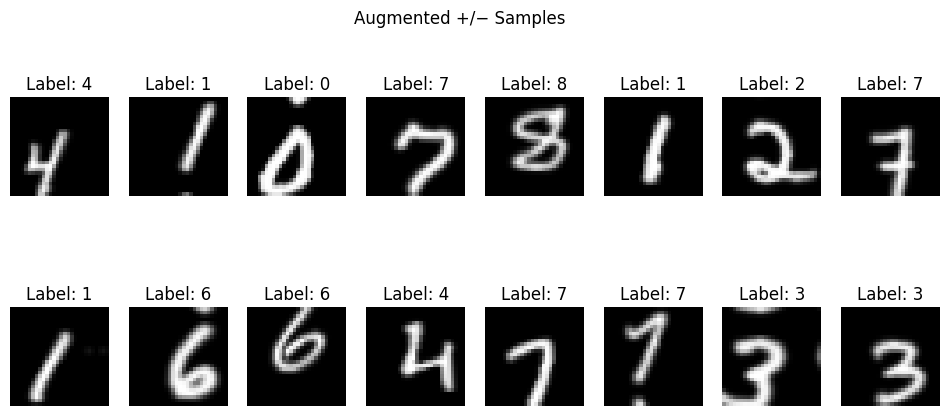

2025-03-20 10:11:41.066554: I tensorflow/core/framework/local_rendezvous.cc:407] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence


In [41]:
import matplotlib.pyplot as plt

# Suppose ds_custom_train is already unbatched:
#  1) Take 16 examples
ds_debug = ds_train.take(16)

#  2) Apply the same transformations you do in training
ds_debug = ds_debug.map(normalize_img, num_parallel_calls=tf.data.AUTOTUNE)
ds_debug = ds_debug.map(
    lambda x, y: (data_augmentation(x, training=True), y),
    num_parallel_calls=tf.data.AUTOTUNE
)

#  3) Batch them together so we can fetch them in one go
ds_debug = ds_debug.batch(16)

#  4) Grab that single batch and plot
for images, labels in ds_debug.take(1):
    plt.figure(figsize=(12, 5))
    for i in range(images.shape[0]):
        ax = plt.subplot(2, 8, i + 1)
        # Convert the Tensor to NumPy and remove the single color channel
        plt.imshow(images[i].numpy().squeeze(), cmap='gray')
        plt.title(f"Label: {labels[i].numpy()}")
        plt.axis("off")
    plt.suptitle("Augmented +/− Samples")
    plt.show()


In [42]:


# Combine training sets
ds_train_combined = ds_train.concatenate(ds_custom_train)
ds_train_combined = ds_train_combined.shuffle(10000)  # reshuffle after concatenation

# Combine validation sets
ds_val_combined = ds_val.concatenate(ds_custom_val)

# Combine test sets
ds_test_combined = ds_test.concatenate(ds_custom_test)


### Normilize both datasets

In [43]:
# Apply to combined datasets
ds_train_combined = preprocess_dataset(ds_train_combined, training=True)
ds_val_combined   = preprocess_dataset(ds_val_combined,   training=False)
ds_test_combined  = preprocess_dataset(ds_test_combined,  training=False)

### Build a training and an evaluation pipeline

### Create and train the model

In [45]:
import keras
from keras.models import Sequential
from keras.layers import Reshape, Conv2D, MaxPooling2D, Flatten, Dense
from keras.optimizers import Adam
from keras.losses import SparseCategoricalCrossentropy
from keras.metrics import SparseCategoricalAccuracy

# Example:
model = Sequential([
    Reshape((28, 28, 1), input_shape=(28, 28)),
    Conv2D(32, (3, 3), activation='relu'),
    MaxPooling2D((2, 2)),
    Conv2D(64, (3, 3), activation='relu'),
    MaxPooling2D((2, 2)),
    Flatten(),
    Dense(128, activation='relu'),
    Dense(12)  # 12 outputs for digits 0-9 plus (10, 11) for +/-.
])

model.compile(
    optimizer=Adam(0.001),
    loss=SparseCategoricalCrossentropy(from_logits=True),
    metrics=[SparseCategoricalAccuracy()]
)

model.fit(
    ds_train_combined,
    epochs=20,
    validation_data=ds_val_combined,
)


Epoch 1/20


/Users/mariiakokina/Downloads/py39env/lib/python3.9/site-packages/keras/src/layers/reshaping/reshape.py:39: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


802/802 ━━━━━━━━━━━━━━━━━━━━ 18s 20ms/step - loss: 0.8838 - sparse_categorical_accuracy: 0.7086 - val_loss: 0.2118 - val_sparse_categorical_accuracy: 0.9376
Epoch 2/20
802/802 ━━━━━━━━━━━━━━━━━━━━ 17s 21ms/step - loss: 0.2473 - sparse_categorical_accuracy: 0.9251 - val_loss: 0.0980 - val_sparse_categorical_accuracy: 0.9696
Epoch 3/20
802/802 ━━━━━━━━━━━━━━━━━━━━ 17s 21ms/step - loss: 0.1666 - sparse_categorical_accuracy: 0.9488 - val_loss: 0.0618 - val_sparse_categorical_accuracy: 0.9834
Epoch 4/20
802/802 ━━━━━━━━━━━━━━━━━━━━ 17s 21ms/step - loss: 0.1299 - sparse_categorical_accuracy: 0.9606 - val_loss: 0.0728 - val_sparse_categorical_accuracy: 0.9778
Epoch 5/20
802/802 ━━━━━━━━━━━━━━━━━━━━ 17s 21ms/step - loss: 0.1150 - sparse_categorical_accuracy: 0.9646 - val_loss: 0.0525 - val_sparse_categorical_accuracy: 0.9846
Epoch 6/20
802/802 ━━━━━━━━━━━━━━━━━━━━ 17s 21ms/step - loss: 0.0933 - sparse_categorical_accuracy: 0.9712 - val_loss: 0.0545 - val_sparse_categorical_accuracy: 0.9835
Epo

In [46]:
import keras

# Evaluate on val set
train_loss, train_acc = model.evaluate(ds_train_combined, verbose=1)

# Evaluate on test set
test_loss, test_acc = model.evaluate(ds_test_combined, verbose=1)

# Save model using keras
keras.saving.save_model(model, "../joblib/cnn_model_aug.keras", save_format="keras")


802/802 ━━━━━━━━━━━━━━━━━━━━ 7s 8ms/step - loss: 0.0384 - sparse_categorical_accuracy: 0.9884
125/125 ━━━━━━━━━━━━━━━━━━━━ 1s 8ms/step - loss: 0.0409 - sparse_categorical_accuracy: 0.9886


In [48]:
# 1. Get Predictions from the combined test dataset
y_pred_prob = model.predict(ds_test_combined)  # predicted probabilities
y_pred = keras.ops.argmax(y_pred_prob, axis=1)  # predicted class labels

# 2. Get True Labels from the combined test dataset
y_true = keras.ops.concatenate([y for _, y in ds_test_combined], axis=0)

# 3. Compute Precision, Recall, and F1-score for each class
# Option: You can also set num_classes = 12 if you know there are 12 classes.
num_classes = keras.ops.max(y_true).numpy() + 1

for class_id in range(num_classes):
    # Create binary indicators for the current class
    true_binary = keras.ops.cast(keras.ops.equal(y_true, class_id), 'float32')
    pred_binary = keras.ops.cast(keras.ops.equal(y_pred, class_id), 'float32')
    
    # Initialize metrics for the current class
    precision_metric = keras.metrics.Precision()
    recall_metric = keras.metrics.Recall()
    
    # Update state with the binary labels
    precision_metric.update_state(true_binary, pred_binary)
    recall_metric.update_state(true_binary, pred_binary)
    
    # Retrieve metric values
    precision_value = precision_metric.result().numpy()
    recall_value = recall_metric.result().numpy()
    
    # Compute F1-score manually (avoiding division by zero)
    f1_value = 2 * (precision_value * recall_value) / (precision_value + recall_value + 1e-7)
    
    print(f"Class {class_id}:")
    print(f"  Precision: {precision_value:.4f}")
    print(f"  Recall:    {recall_value:.4f}")
    print(f"  F1-score:  {f1_value:.4f}")

# 4. Compute Overall Accuracy
accuracy = keras.metrics.Accuracy()
accuracy.update_state(y_true, y_pred)
print(f"\nOverall Accuracy: {accuracy.result().numpy():.4f}")


  1/125 ━━━━━━━━━━━━━━━━━━━━ 2s 21ms/step

125/125 ━━━━━━━━━━━━━━━━━━━━ 1s 8ms/step
Class 0:
  Precision: 0.9969
  Recall:    0.9908
  F1-score:  0.9939
Class 1:
  Precision: 0.9956
  Recall:    0.9912
  F1-score:  0.9934
Class 2:
  Precision: 0.9865
  Recall:    0.9932
  F1-score:  0.9899
Class 3:
  Precision: 0.9673
  Recall:    0.9970
  F1-score:  0.9820
Class 4:
  Precision: 0.9858
  Recall:    0.9908
  F1-score:  0.9883
Class 5:
  Precision: 0.9864
  Recall:    0.9787
  F1-score:  0.9826
Class 6:
  Precision: 0.9947
  Recall:    0.9875
  F1-score:  0.9911
Class 7:
  Precision: 0.9893
  Recall:    0.9864
  F1-score:  0.9878
Class 8:
  Precision: 0.9797
  Recall:    0.9918
  F1-score:  0.9857
Class 9:
  Precision: 0.9990
  Recall:    0.9633
  F1-score:  0.9808
Class 10:
  Precision: 0.9970
  Recall:    1.0000
  F1-score:  0.9985
Class 11:
  Precision: 1.0000
  Recall:    1.0000
  F1-score:  1.0000

Overall Accuracy: 0.9920


2025-03-20 10:19:17.247833: I tensorflow/core/framework/local_rendezvous.cc:407] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence
